In [218]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [219]:
SPY_2DAY = pd.read_csv('E-mini S&P 500 minute data (2 days).csv')

In [220]:
def load_data():
    df = pd.read_csv(
        'E-mini S&P 500 minute data (2 days).csv', header=1)
    cols = ["Date Time", "Close"]
    data = df[cols]
    data = data.set_axis(["timestamp", "close"], axis=1)
    return data


def deltas():
    df = load_data()
    df["log"] = np.log(df["close"].astype(float))
    df["deltas"] = df["log"].diff()
    df.dropna(inplace=True)
    final_data = df[["timestamp", "close", "deltas"]]
    #final_data = final_data.set_axis(["timestamp", "close", "deltas"], axis=1)
    return final_data

In [221]:
data = deltas()

In [222]:
data[(data['timestamp'] >= '2022-02-09') & (data['timestamp'] < '2022-02-10')]

,timestamp,close,deltas
1,2022-02-09 07:15:00,4556.50,0.000165
2,2022-02-09 07:16:00,4556.00,-0.000110
3,2022-02-09 07:17:00,4556.25,0.000055
4,2022-02-09 07:18:00,4555.75,-0.000110
5,2022-02-09 07:19:00,4555.25,-0.000110
...,...,...,...
941,2022-02-09 23:55:00,4568.75,0.000219
942,2022-02-09 23:56:00,4569.25,0.000109
943,2022-02-09 23:57:00,4569.75,0.000109
944,2022-02-09 23:58:00,4571.75,0.000438


In [223]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

In [224]:
df_testing = pd.DataFrame(np.log(data.close).diff().diff(12))
adf_check(df_testing.close.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -16.64043101577222
p-value : 1.6364587817445258e-29
Number of Lags Used : 23
Number of Observations Used : 1882
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [225]:
data

,timestamp,close,deltas
1,2022-02-09 07:15:00,4556.50,0.000165
2,2022-02-09 07:16:00,4556.00,-0.000110
3,2022-02-09 07:17:00,4556.25,0.000055
4,2022-02-09 07:18:00,4555.75,-0.000110
5,2022-02-09 07:19:00,4555.25,-0.000110
...,...,...,...
1915,2022-02-10 17:09:00,4491.00,-0.000612
1916,2022-02-10 17:10:00,4493.00,0.000445
1917,2022-02-10 17:11:00,4493.25,0.000056
1918,2022-02-10 17:12:00,4494.25,0.000223


In [226]:

def AR(p, df):
#Generating the lagged p terms
    df_temp = df

    for i in range(1,p+1):
        df_temp['Shifted_values_%d' % i ] = df_temp['close'].shift(i)

    train_size = (int)(0.8 * df_temp.shape[0])

    #Breaking data set into test and training
    df_train = pd.DataFrame(df_temp[0:train_size])
    df_test = pd.DataFrame(df_temp[train_size:df_temp.shape[0]])

    df_train_2 = df_train.dropna()
    #X contains the lagged values ,hence we skip the first column
    try:
        X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
    except:
        return [pd.DataFrame(), pd.DataFrame(), 0, 0, float("inf")]
    #Y contains the value,it is the first column
    y_train = df_train_2.iloc[:,1].values.reshape(-1,1)

    #Running linear regression to generate the coefficents of lagged terms
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
    # df_train_2[['Value','Predicted_Values']].plot()

    X_test = df_test.iloc[:,1:].values.reshape(-1,p)
    df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
    # df_test[['Value','Predicted_Values']].plot()

    RMSE = np.sqrt(mean_squared_error(df_test['close'], df_test['Predicted_Values']))

    print("The RMSE is :", RMSE,", Value of p : ",p)
    return [df_train_2,df_test,theta,intercept,RMSE]

In [227]:
def opt_p (df_testing, low_p, up_p):
  best_p = 0
  best_rmse = float("inf")
  for p in range(low_p, up_p):
    df_train_2,df_test,theta,intercept,RMSE = AR(p, pd.DataFrame(df_testing))
    if RMSE<best_rmse:
      best_p = p
      best_rmse = RMSE
  return best_p, best_rmse


In [228]:
df_train_2,df_test,theta,intercept,RMSE = AR(10, df_testing)
df_c = pd.concat([df_train_2,df_test])
res = pd.DataFrame()
res['Residuals'] = df_c.close - df_c.Predicted_Values

The RMSE is : 0.0011368740889626352 , Value of p :  1
The RMSE is : 0.0011368740889626352 , Value of p :  2
The RMSE is : 0.0011368740889626354 , Value of p :  3


<ipython-input-226-ec46fddca803>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-226-ec46fddca803>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-226-ec46fddca803>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

The RMSE is : 0.0011368740889626347 , Value of p :  4
The RMSE is : 0.0011368740889626356 , Value of p :  5
The RMSE is : 0.0011368740889626356 , Value of p :  6
The RMSE is : 0.0011368740889626352 , Value of p :  7
The RMSE is : 0.0011368740889626352 , Value of p :  8
The RMSE is : 0.0011368740889626347 , Value of p :  9
The RMSE is : 0.0011368740889626345 , Value of p :  10
The RMSE is : 0.0011368740889626352 , Value of p :  11
The RMSE is : 0.0011368740889626352 , Value of p :  12


<ipython-input-226-ec46fddca803>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-226-ec46fddca803>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-226-ec46fddca803>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

The RMSE is : 0.0011368740889626356 , Value of p :  13
The RMSE is : 0.001136874088962635 , Value of p :  14
The RMSE is : 0.0011368740889626356 , Value of p :  15
The RMSE is : 0.0011368740889626354 , Value of p :  16
The RMSE is : 0.0011368740889626352 , Value of p :  17
The RMSE is : 0.0011368740889626347 , Value of p :  18
The RMSE is : 0.0011368740889626356 , Value of p :  19
The RMSE is : 0.001136874088962635 , Value of p :  20
The RMSE is : 0.0011368740889626345 , Value of p :  10


<ipython-input-226-ec46fddca803>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
<ipython-input-226-ec46fddca803>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_


In [229]:
res

,Residuals
24,-0.000165
25,-0.000110
26,0.000329
27,0.000055
28,0.000274
...,...
1915,-0.000278
1916,0.000724
1917,-0.000278
1918,0.000723


In [230]:
def MA(q,res):

    for i in range(1,q+1):
        res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

    train_size = (int)(0.8 * res.shape[0])

    res_train = pd.DataFrame(res[0:train_size])
    res_test = pd.DataFrame(res[train_size:res.shape[0]])

    res_train_2 = res_train.dropna()
    X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
    y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
    # res_train_2[['Residuals','Predicted_Values']].plot()

    X_test = res_test.iloc[:,1:].values.reshape(-1,q)
    res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
    res_test[['Residuals','Predicted_Values']].plot()

    from sklearn.metrics import mean_squared_error
    RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

    print("The RMSE is :", RMSE,", Value of q : ",q)
    return [res_train_2,res_test,theta,intercept,RMSE]

<ipython-input-230-2b8a30d6bfeb>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_


The RMSE is : 0.0008400132150945491 , Value of q :  10


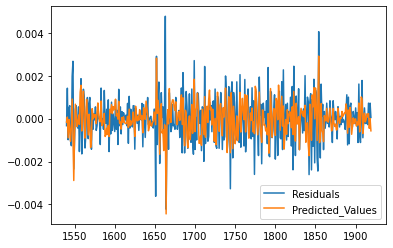

In [231]:
res_train_2,res_test,theta,intercept,RMSE = MA(10, res)

In [232]:
[df_train,df_test,theta,intercept,RMSE] = AR(10,df_testing)

The RMSE is : 0.0011368740889626345 , Value of p :  10


<ipython-input-226-ec46fddca803>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_


<AxesSubplot:>

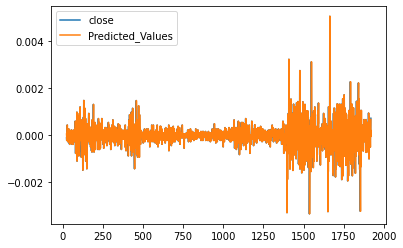

In [233]:
df_c = pd.concat([df_train_2,df_test])
df_c[['close','Predicted_Values']].plot()
# df_c

In [234]:
res = pd.DataFrame()
res['Residuals'] = df_c.close - df_c.Predicted_Values

In [235]:
res_c = pd.concat([res_train_2,res_test])


In [236]:
res_c

,Residuals,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,Shifted_values_10,Predicted_Values
34,0.000384,1.097574e-04,-4.390448e-04,5.485613e-05,2.195510e-04,-5.488896e-04,0.000274,0.000055,0.000329,-0.000110,-0.000165,1.447562e-04
35,-0.000220,3.842188e-04,1.097574e-04,-4.390448e-04,5.485613e-05,2.195510e-04,-0.000549,0.000274,0.000055,0.000329,-0.000110,-2.225719e-04
36,0.000055,-2.195721e-04,3.842188e-04,1.097574e-04,-4.390448e-04,5.485613e-05,0.000220,-0.000549,0.000274,0.000055,0.000329,4.691217e-05
37,0.000220,5.489227e-05,-2.195721e-04,3.842188e-04,1.097574e-04,-4.390448e-04,0.000055,0.000220,-0.000549,0.000274,0.000055,1.276187e-05
38,-0.000439,2.196233e-04,5.489227e-05,-2.195721e-04,3.842188e-04,1.097574e-04,-0.000439,0.000055,0.000220,-0.000549,0.000274,-1.446701e-04
...,...,...,...,...,...,...,...,...,...,...,...,...
1915,-0.000278,1.857213e-08,-2.223393e-04,-2.228502e-04,5.009075e-04,-1.668566e-04,-0.000891,0.001781,-0.000056,-0.001113,-0.000780,9.414797e-05
1916,0.000724,-2.783669e-04,1.857213e-08,-2.223393e-04,-2.228502e-04,5.009075e-04,-0.000167,-0.000891,0.001781,-0.000056,-0.001113,2.330601e-04
1917,-0.000278,7.235998e-04,-2.783669e-04,1.857213e-08,-2.223393e-04,-2.228502e-04,0.000501,-0.000167,-0.000891,0.001781,-0.000056,-4.522948e-04
1918,0.000723,-2.783174e-04,7.235998e-04,-2.783669e-04,1.857213e-08,-2.223393e-04,-0.000223,0.000501,-0.000167,-0.000891,0.001781,-4.888779e-07


In [237]:
df_c.Predicted_Values += res_c.Predicted_Values

<AxesSubplot:>

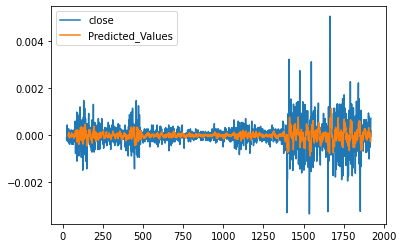

In [238]:
df_c[['close','Predicted_Values']].plot()

In [239]:
df_c.close += np.log(data.close).shift(1)
df_c.close += np.log(data.close).diff().shift(12)
df_c.Predicted_Values += np.log(data.close ).shift(1)
df_c.Predicted_Values += np.log(data.close).diff().shift(12)
df_c.close = np.exp(df_c.close)
df_c.Predicted_Values = np.exp(df_c.Predicted_Values)

In [240]:
df_c

,close,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,Shifted_values_10,Predicted_Values
24,4554.25,0.000055,-0.000055,1.646316e-04,1.646497e-04,-1.097394e-04,-2.195239e-04,1.646497e-04,-0.000055,-0.000165,0.000165,NaN
25,4553.00,-0.000110,0.000055,-5.492240e-05,1.646316e-04,1.646497e-04,-1.097394e-04,-2.195239e-04,0.000165,-0.000055,-0.000165,NaN
26,4553.75,-0.000220,-0.000110,5.489529e-05,-5.492240e-05,1.646316e-04,1.646497e-04,-1.097394e-04,-0.000220,0.000165,-0.000055,NaN
27,4554.00,0.000110,-0.000220,-1.097635e-04,5.489529e-05,-5.492240e-05,1.646316e-04,1.646497e-04,-0.000110,-0.000220,0.000165,NaN
28,4555.25,0.000165,0.000110,-2.196264e-04,-1.097635e-04,5.489529e-05,-5.492240e-05,1.646316e-04,0.000165,-0.000110,-0.000220,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1915,4491.00,-0.000223,-0.000223,-1.950725e-07,2.226552e-04,-2.782524e-04,-1.113957e-04,7.792869e-04,-0.001002,-0.000946,0.000167,4492.673276
1916,4493.00,-0.000501,-0.000223,-2.225344e-04,-1.950725e-07,2.226552e-04,-2.782524e-04,-1.113957e-04,0.000779,-0.001002,-0.000946,4490.796546
1917,4493.25,0.000223,-0.000501,-2.225158e-04,-2.225344e-04,-1.950725e-07,2.226552e-04,-2.782524e-04,-0.000111,0.000779,-0.001002,4492.468344
1918,4494.25,-0.000056,0.000223,-5.008827e-04,-2.225158e-04,-2.225344e-04,-1.950725e-07,2.226552e-04,-0.000278,-0.000111,0.000779,4490.998875


close                 0
Shifted_values_1      0
Shifted_values_2      0
Shifted_values_3      0
Shifted_values_4      0
Shifted_values_5      0
Shifted_values_6      0
Shifted_values_7      0
Shifted_values_8      0
Shifted_values_9      0
Shifted_values_10     0
Predicted_Values     10
dtype: int64

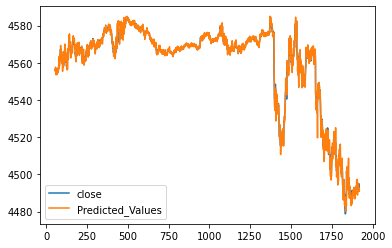

In [241]:
df_c.iloc[30:,:][['close','Predicted_Values']].plot()
np.sum(df_c.isna())